# 2. Generating a Sample using MS1 Controller

In this notebook, we demonstrate how ViMMS can be used to generate a full-scan mzML file from a set of simulated chemicals with characteristics that resemble actual experimental data. This corresponds to Section 3.1 of the paper.

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../..')

In [4]:
import os
from pathlib import Path
import pylab as plt

In [5]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import SimpleMs1Controller
from vimms.Environment import Environment
from vimms.Common import POSITIVE, load_obj, save_obj, set_log_level_debug, set_log_level_warning
from vimms.ChemicalSamplers import DatabaseFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler, MZMLMS2Sampler
from vimms.Roi import RoiBuilderParams
from vimms.Chemicals import ChemicalMixtureCreator

Load list of extracted metabolites, created in **01. Download Data.ipynb**.

In [6]:
base_dir = os.path.abspath('example_data')
hmdb = load_obj(Path(base_dir, 'hmdb_compounds.p'))

## Create Chemicals

Define an output folder containing our results

In [7]:
out_dir = Path('results', 'MS1_single')

Here we generate the chemical objects that will be used in the sample. The chemical objects are generated by sampling from metabolites in the HMDB database.

#### Sample m/z values from the chemical formulae in HMDB

In [8]:
HMDB = os.path.join(base_dir, 'hmdb_compounds.p')
hmdb = load_obj(HMDB)

In [9]:
# create a database formula sampler that will sample from HMDB with m/z between 100 and 1000
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)

Plot sampled m/z distribution of formulae

2023-07-17 12:11:54.754 | DEBUG    | vimms.ChemicalSamplers:sample:84 - 73822 unique formulas in filtered database
2023-07-17 12:11:54.756 | DEBUG    | vimms.ChemicalSamplers:sample:90 - Sampled formulas


(array([ 56.,  72.,  67.,  56.,  52.,  53.,  91., 153., 223., 177.]),
 array([100.0524295 , 187.92395065, 275.7954718 , 363.66699295,
        451.53851411, 539.41003526, 627.28155641, 715.15307756,
        803.02459871, 890.89611986, 978.76764101]),
 <BarContainer object of 10 artists>)

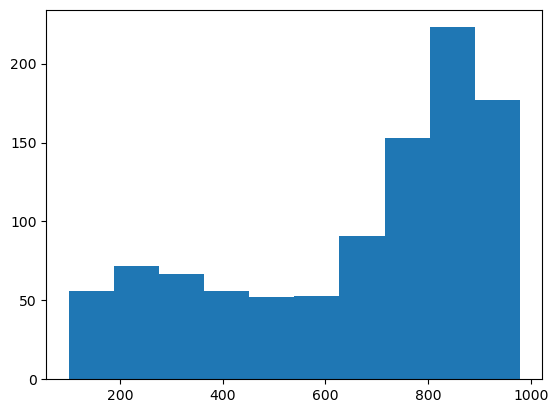

In [10]:
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

Define the mzML file from which we'll sample various distributions for generating data, e.g. RT, intensity, chromatograms, MS2 spectra.

Here we set a very high threshold (1.75E5) on the minimum MS1 intensity of chemicals to be considered when generating various distributions. This is to allow the notebook to run fast. For a more accurate simulation, you should decrease this to a a lower value, e.g. 1E4.

In [11]:
MZML = os.path.join(base_dir, 'Beer_multibeers_1_T10_POS.mzML')

In [12]:
min_ms1_intensity = 1.75E5
roi_params = RoiBuilderParams(at_least_one_point_above=min_ms1_intensity)

#### Sample RT and intensity values from an actual experimental mzML file

In [13]:
ri = MZMLRTandIntensitySampler(MZML, roi_params=roi_params)

2023-07-17 12:11:56.794 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9423 scans


Plot sampled RT and intensity distributions

(array([887.,  63.,  21.,  10.,   8.,   2.,   4.,   0.,   2.,   3.]),
 array([ 175263.30466325, 1128205.54059268, 2081147.77652211,
        3034090.01245153, 3987032.24838096, 4939974.48431038,
        5892916.72023981, 6845858.95616923, 7798801.19209866,
        8751743.42802808, 9704685.66395751]),
 <BarContainer object of 10 artists>)

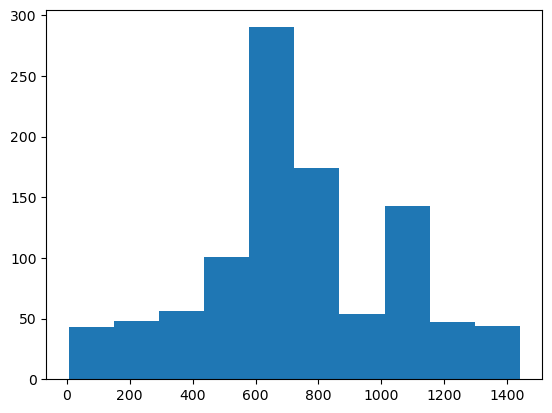

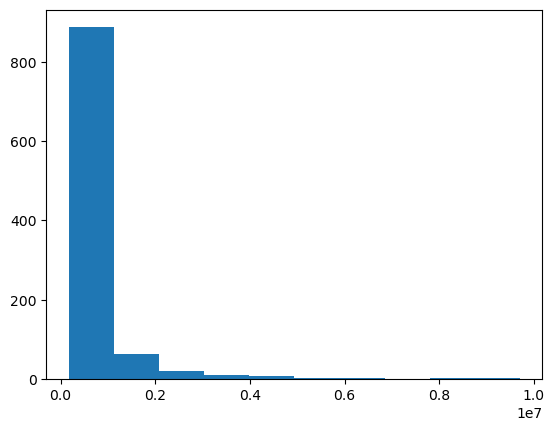

In [14]:
rt_list = []
intensity_list = []

for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)

plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

#### Sample chromatograms from mzML file

In [15]:
cs = MZMLChromatogramSampler(MZML, roi_params=roi_params)

2023-07-17 12:13:04.485 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:491 - Extracted 10062 good ROIs from /Users/joewandy/Work/git/vimms/examples/01. vimms (Wandy et al 2019)/example_data/Beer_multibeers_1_T10_POS.mzML


#### Sample MS2 spectra from mzML file

In [16]:
ms = MZMLMS2Sampler(MZML)

2023-07-17 12:13:06.235 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 9423 scans
2023-07-17 12:13:06.331 | DEBUG    | vimms.ChemicalSamplers:_filter_scans:832 - 7672 MS2 scansn remaining


## Put everything together

Generate `num_chems` number of UnknownChemicals objects up to the highest MS level specified.

In [17]:
num_chems = 6500
ms_level = 2

cm = ChemicalMixtureCreator(df, rt_and_intensity_sampler=ri, chromatogram_sampler=cs, ms2_sampler=ms)
dataset = cm.sample(num_chems, ms_level)

2023-07-17 12:13:08.277 | DEBUG    | vimms.ChemicalSamplers:sample:84 - 73822 unique formulas in filtered database
2023-07-17 12:13:08.279 | DEBUG    | vimms.ChemicalSamplers:sample:90 - Sampled formulas
2023-07-17 12:13:08.751 | DEBUG    | vimms.Chemicals:sample:664 - Sampled rt and intensity values and chromatograms


In [18]:
save_obj(dataset, Path(out_dir, 'dataset.p'))

2023-07-17 12:13:13.363 | INFO     | vimms.Common:save_obj:473 - Saving <class 'list'> to results/MS1_single/dataset.p


In [19]:
for chem in dataset[0:10]:
    print(chem)

KnownChemical - 'C28H54O5' rt=299.52 max_intensity=222471.08
KnownChemical - 'C59H114O6' rt=1387.06 max_intensity=706473.84
KnownChemical - 'C27H29O18' rt=455.29 max_intensity=653078.25
KnownChemical - 'C58H102O6' rt=624.32 max_intensity=452277.16
KnownChemical - 'C26H28O13' rt=725.72 max_intensity=228533.52
KnownChemical - 'C34H68O2' rt=615.46 max_intensity=201224.87
KnownChemical - 'C5H9NO5' rt=883.99 max_intensity=467516.11
KnownChemical - 'C51H98O6' rt=1118.64 max_intensity=205109.92
KnownChemical - 'C50H96O6' rt=788.80 max_intensity=196944.61
KnownChemical - 'C48H92O6' rt=1091.42 max_intensity=201799.85


## Run MS1 controller on the samples and generate .mzML files

In [20]:
rt_range = [(0, 1440)]
min_rt = rt_range[0][0]
max_rt = rt_range[0][1]

In [21]:
# set the log level to WARNING so we don't see too many messages when environment is running
set_log_level_warning()

1

In [22]:
mass_spec = IndependentMassSpectrometer(POSITIVE, dataset)
controller = SimpleMs1Controller()

Run the simulation. Disable the progress bar to make it run faster.

In [23]:
# create an environment to run both the mass spec and controller
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)

# run the simulation
env.run()

  0%|          | 0/1440 [00:00<?, ?it/s]

Simulated results are saved to the following .mzML file and can be viewed in tools like [ToppView](https://pubs.acs.org/doi/abs/10.1021/pr900171m) or using other mzML file viewers.

In [24]:
mzml_filename = 'ms1_controller.mzML'
env.write_mzML(out_dir, mzml_filename)